In [16]:
from quantumreservoirpy import util
from quantumreservoirpy.reservoirs import Static, Incremental

from qiskit.quantum_info import Clifford, random_clifford
from qiskit.extensions import HamiltonianGate
from qiskit.circuit.library import PauliGate
from qiskit.circuit.library import RYGate, RZGate, RZZGate

In [17]:
import numpy as np


class Stabilizer(Static):
    def __init__(self, n_qubits, encoder, *args, **kwargs) -> None:
        super().__init__(n_qubits , *args, **kwargs)
        self.n_logical = n_qubits
        self.encoder = encoder

        OP = random_clifford(n_qubits)

        
        H = util.random_ising_H(num_qubits=self.n_logical, num_terms=40)
        T = 10 #s
        self.reservoir = HamiltonianGate(H, T, label="UT")

        cliff = Clifford(OP)
        ops = [elem[-self.n_logical:] for elem in cliff.stabilizer.to_labels()]
        self.ops = [PauliGate(elem).control(1) for elem in ops]

    def before(self, circuit):
        circuit.reset(circuit.qubits)
        
    def during(self, circuit, timestep):
        circuit.barrier()

        circuit.measure([0, 1])
        circuit.initialize('+', 0)
        circuit.initialize('+',1)
        circuit.append(self.encoder[timestep], [0, 1])
        
        circuit.append(self.reservoir, range(self.n_logical))

    


In [18]:
encoder = {}
timestep = [i for i in range(10)]
timeseries = timestep * 10
SHOTS = 50000
n_qubits = 4
N = np.unique(timestep).size
epsilon = np.random.random() 
for idx, elem in enumerate(np.unique(timestep)):
    theta = idx * 2 * np.pi / N + epsilon
    encoder[elem] = RZZGate(theta, str(elem))
    # encoder[elem] = ('0'*N + bin(idx)[2:])[-2:]


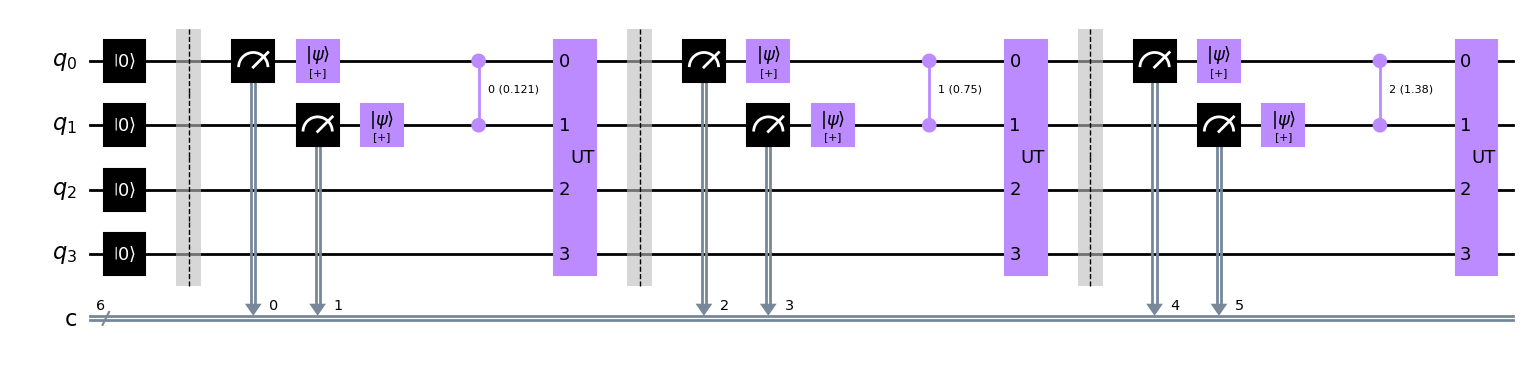

In [19]:

qres = Stabilizer(
    n_qubits=n_qubits,
    encoder=encoder
)

qres.circuit([0, 1, 2], merge_registers=True, transpile=False).draw('mpl')

In [20]:
states = qres.run(
    timeseries=timeseries, 
    shots=SHOTS,
)


In [21]:

WARMUP = 0.2 # 10%
warmup_idx = int(len(states) * WARMUP)

xstates = states[:-1][warmup_idx:]
target = timeseries[1:][warmup_idx:]


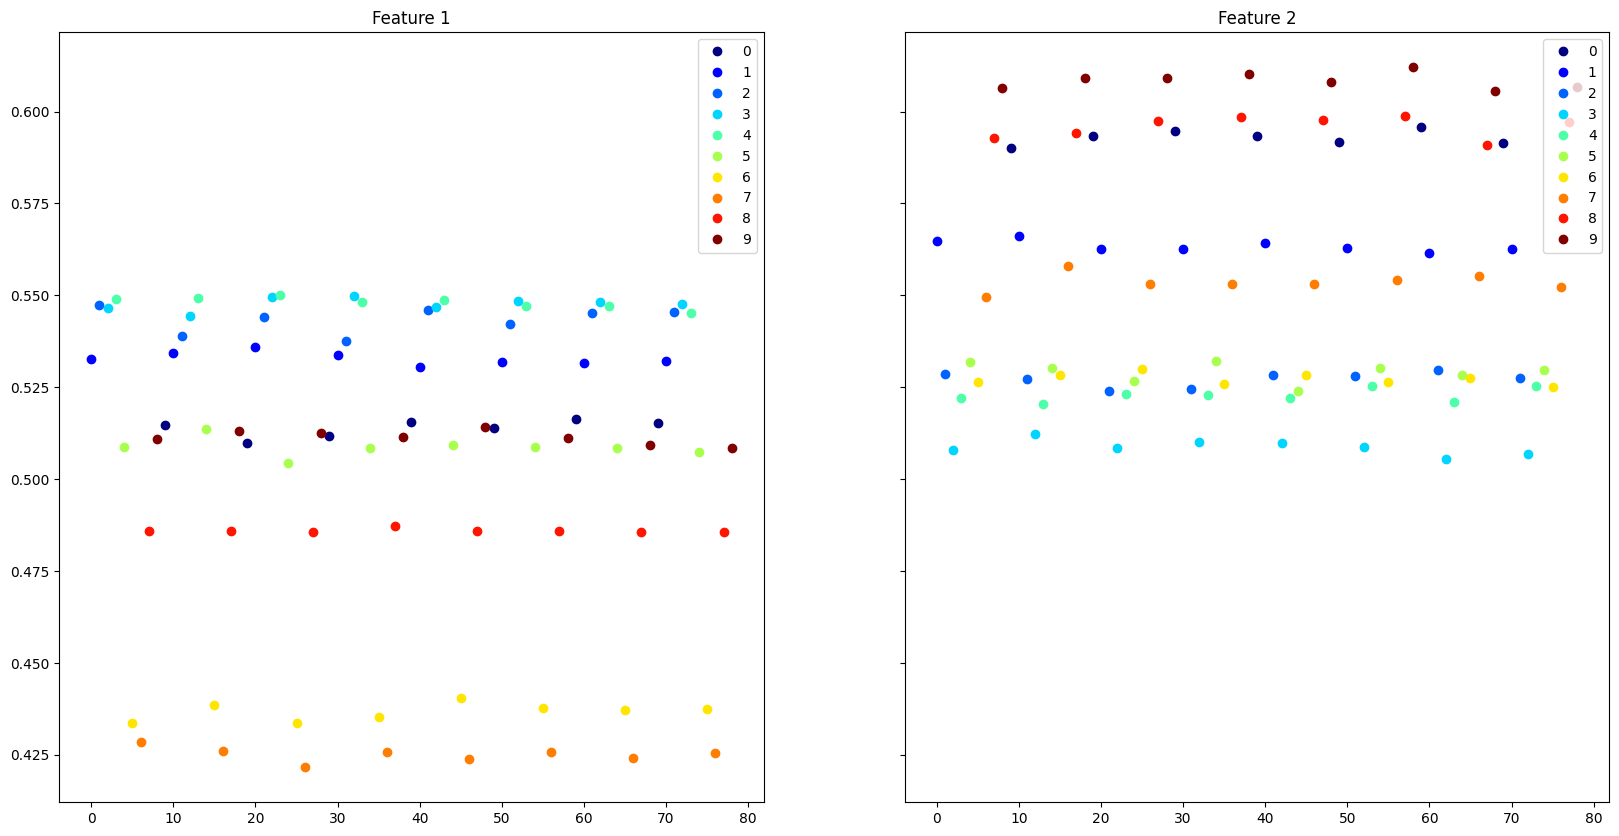

In [22]:
from quantumreservoirpy.plot import state_plotter
fig, ax = state_plotter(xstates, target)

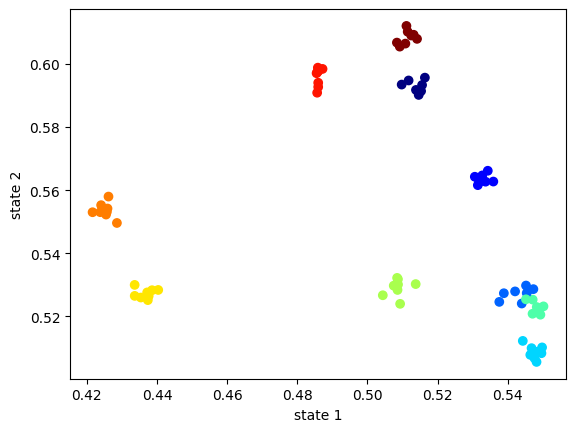

In [23]:
from quantumreservoirpy.plot import feature_plotter
fig, ax = feature_plotter(xstates, target)


In [24]:
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
models = np.array([
    SVC(kernel=ker, max_iter=1000) for ker in ['linear', 'poly', 'rbf', 'sigmoid']
] 
# + [
#     RidgeClassifier(alpha=alph, max_iter=1000) for alph in np.linspace(0, 1e-3, 9)
# ] 
+ [
    KNeighborsClassifier(n_neighbors=n) for n in range(1, 10)
]
, dtype=object)

In [25]:
import warnings
warnings.filterwarnings('ignore')

results = util.stress_test_models(xstates, target, models, test_to_train_ratio=1/3)
sorting = np.flip(np.argsort(results))
for model, res in zip(models[sorting], results[sorting]):
    print(f'Score of {model}: {res}')
    

model = models[sorting][0]


Score of KNeighborsClassifier(n_neighbors=2): 0.9759259259259255
Score of KNeighborsClassifier(n_neighbors=1): 0.9744444444444439
Score of KNeighborsClassifier(n_neighbors=3): 0.9699999999999995
Score of SVC(kernel='poly', max_iter=1000): 0.9644444444444438
Score of KNeighborsClassifier(n_neighbors=4): 0.9529629629629623
Score of KNeighborsClassifier(): 0.9344444444444437
Score of KNeighborsClassifier(n_neighbors=6): 0.8870370370370366
Score of KNeighborsClassifier(n_neighbors=7): 0.827407407407407
Score of KNeighborsClassifier(n_neighbors=8): 0.727407407407407
Score of SVC(max_iter=1000): 0.6825925925925924
Score of KNeighborsClassifier(n_neighbors=9): 0.6281481481481479
Score of SVC(kernel='linear', max_iter=1000): 0.06888888888888893
Score of SVC(kernel='sigmoid', max_iter=1000): 0.03296296296296299


In [26]:
num_preds = 40
predict_from = timeseries[-num_preds:]

assert(0 == 1)

preds = qres.predict(
    num_pred=num_preds,
    model=model,
    shots=SHOTS,
    from_series=predict_from
)


AssertionError: 

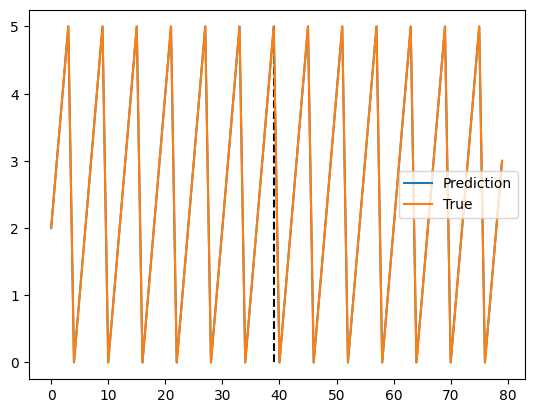

In [ ]:
import matplotlib.pyplot as plt
pred_plot = np.append(predict_from, preds)
true_plot = np.append(predict_from, timeseries[:len(pred_plot) - len(predict_from)])
plt.plot(pred_plot, label="Prediction")
plt.vlines(len(predict_from)-1, ymin=np.min(target), ymax=np.max(target), colors='k', linestyles='dashed')

plt.plot(true_plot, label="True")
# plt.xlim([60, 80])
plt.legend()
